In [1]:
import os
import sys
import copy
from collections import defaultdict
from tqdm.notebook import tqdm
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataloader
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.data_utils import data_utils
from utils.fetch_features import *
from utils.torch_utils import torch_utils

random.seed(35)
plt.style.use("seaborn")
%matplotlib inline

print("torch.version:  ", torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("current_device: ", device)

if torch.cuda.is_available():
    print("device_name:    ", torch.cuda.get_device_name(device))
    #     print("device_count:   ", torch.cuda.device_count())
    #     print("current_device: ", torch.cuda.current_device())
    torch.cuda.empty_cache()

torch.version:   1.8.0+cu111
current_device:  cuda:0
device_name:     GeForce RTX 3090


# data read

In [2]:
# -----------------------------
# read free explore motion primitive data
# -----------------------------

file_path = os.path.join(os.path.dirname(os.getcwd()), "archive", "processed", "cap_59d.pickle")
cap_dict = data_utils.read_from_pickle(file_path)

DATA_FEATURE_NUM = len(cap_dict[list(cap_dict.keys())[0]][0][0])
print("DATA_FEATURE_NUM: ", DATA_FEATURE_NUM)

In [ ]:
# -----------------------------
# read segmented trajectory data
# -----------------------------

data_path = os.path.join(os.path.dirname(os.getcwd()), "archive", "processed", "traj_stationary_59d.pickle")
traj_list = data_utils.read_from_pickle(data_path)

DATA_FEATURE_NUM = len(traj_list[0][list(traj_list[0].keys())[0]][0])
print("DATA_FEATURE_NUM: ", DATA_FEATURE_NUM)

# Generate train_loader, test_loader

In [ ]:
# generate train_data & train_label


def z_score_normalization(x, mean, std):
    return (x - mean) / (std + 1e-5)


def get_minibatch_mean_and_std(data_dict):
    mean = 0
    std = 0
    sample_num = 10
    for i in range(sample_num):
        temp_means = []
        temp_stds = []
        for k in data_dict:
            sample_index = np.random.randint(0, len(data_dict[k]), int(0.6 * len(data_dict[k])))
            for index in sample_index:
                index_k_mean = np.mean(np.array(data_dict[k][index]), axis=0)
                index_k_std = np.std(np.array(data_dict[k][index]), axis=0)
                temp_means.append(index_k_mean)
                temp_stds.append(index_k_std)

        mean = mean + np.mean(np.array(temp_means), axis=0)
        #         print('mean: ', np.mean(np.array(temp_means), axis=0))
        std = std + np.mean(np.array(temp_stds), axis=0)

    return (mean / sample_num, std / sample_num)


def generate_train_set(data_dict, clip_length, step, capabilites=FETCH_CAPABILITY_INDEX):
    #     clip_data_dict = data_dict
    clip_data_dict = defaultdict(list)
    for k in data_dict:
        clip_data_dict.setdefault(k, [])
        for file_index in range(len(data_dict[k])):
            data_index = 0
            while data_index < len(data_dict[k][file_index]):
                data_length = clip_length
                if data_index + data_length > len(data_dict[k][file_index]):
                    #                     clip_data_dict[k].append(data_dict[k][file_index][data_index:])
                    break
                clip_data_dict[k].append(data_dict[k][file_index][data_index : data_index + data_length])
                data_index = data_index + step

    z_score_mean, z_score_std = get_minibatch_mean_and_std(data_dict)

    train_data = []
    train_label = []

    for k in clip_data_dict:
        for file_data in clip_data_dict[k]:
            train_data.append(z_score_normalization(np.array(file_data).astype(float), z_score_mean, z_score_std))
            #                 train_data.append(np.array(file_data).astype(float))
            train_label.append(capabilites[k])

    return train_data, train_label, z_score_mean, z_score_std


class Collate_FCN:
    def __init__(self):
        pass

    def _collate(self, batch):

        xs_list = [torch.FloatTensor(v[0]).t() for v in batch]
        xs = torch.FloatTensor()
        for index, data in enumerate(xs_list):
            if index == 0:
                xs = data
            else:
                xs = torch.cat((xs, data), dim=0)

        ys = torch.LongTensor([v[1] for v in batch])
        return xs, ys

    def __call__(self, batch):
        return self._collate(batch)


class Collate_RNN:
    """
    a variant of callate_fn that pads according to the longest sequence in
    a batch of sequences
    """

    def __init__(self):
        pass

    def _collate(self, batch):
        """
        args:
            batch - list of (tensor, label)

        reutrn:
            xs - a tensor of all examples in 'batch' before padding like:
                '''
                [tensor([1,2,3,4]),
                 tensor([1,2]),
                 tensor([1,2,3,4,5])]
                '''
            ys - a LongTensor of all labels in batch like:
                '''
                [1,0,1]
                '''
        """

        xs = [torch.FloatTensor(v[0]).to(device) for v in batch]
        ys = torch.LongTensor([v[1] for v in batch])
        # 获得每个样本的序列长度
        seq_lengths = torch.LongTensor([v for v in map(len, xs)])
        max_len = max([len(v) for v in xs])
        # 每个样本都padding到当前batch的最大长度
        xs = pad_sequence(xs, batch_first=True, padding_value=0)
        # 把xs和ys按照序列长度从大到小排序
        seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
        xs = xs[perm_idx]
        ys = ys[perm_idx]
        return xs, seq_lengths, ys

    #         xs_list = [torch.FloatTensor(v[0]).t() for v in batch]
    #         xs = torch.FloatTensor()
    #         for index, data in enumerate(xs_list):
    #             if index == 0:
    #                 xs = data
    #             else:
    #                 xs = torch.cat((xs, data), dim=0)

    #         ys = torch.LongTensor([v[1] for v in batch])
    #         return xs, ys

    def __call__(self, batch):
        return self._collate(batch)


def train_preprocessing(data_set, test_size, train_batch_size, test_batch_size, clip_length, step, collate_fn):

    print("Generate train set")
    train_data, train_label, z_score_mean, z_score_std = generate_train_set(data_set, clip_length, step)

    print("train_test_split")
    x_train, x_test, y_train, y_test = train_test_split(train_data, train_label, random_state=0, test_size=test_size)

    print("Generating train_loader & test_loader")

    train_loader = dataloader.DataLoader(
        dataset=list(zip(x_train, y_train)), batch_size=train_batch_size, num_workers=0, shuffle=True, collate_fn=collate_fn()
    )

    test_loader = dataloader.DataLoader(
        dataset=list(zip(x_test, y_test)), batch_size=test_batch_size, num_workers=0, shuffle=True, collate_fn=collate_fn()
    )

    return train_loader, test_loader, z_score_mean, z_score_std

In [ ]:
BATCH_SIZE = 256
CLIP_LEN = 200

# training and testing
train_loader, test_loader, z_score_mean, z_score_std = train_preprocessing(
    cap_dict,
    test_size=0.3,
    train_batch_size=BATCH_SIZE,
    test_batch_size=BATCH_SIZE,
    clip_length=CLIP_LEN,
    step=40,
    collate_fn=Collate_RNN,
)

np.save("segment_lstm_mean.npy", z_score_mean)
np.save("segment_lstm_std.npy", z_score_std)

In [ ]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))

# RNN Model

In [15]:
class RNN(nn.Module):
    def __init__(self, n_features):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=n_features,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
        )

        self.hidden1 = torch.nn.Linear(256, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.hidden2 = torch.nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        #         self.hidden3 = torch.nn.Linear(64, 128)
        #         self.bn3 = nn.BatchNorm1d(128)

        self.dropout = nn.Dropout(p=0.5)

        self.out = nn.Linear(64, 4)  # 输出层

        # 初始化层
        nn.init.xavier_normal_(self.rnn.all_weights[0][0])
        nn.init.xavier_normal_(self.rnn.all_weights[0][1])
        nn.init.xavier_normal_(self.out.weight)
        nn.init.constant_(self.out.bias, 0.1)
        nn.init.xavier_normal_(self.hidden1.weight)
        nn.init.constant_(self.hidden1.bias, 0.1)
        nn.init.xavier_normal_(self.hidden2.weight)
        nn.init.constant_(self.hidden2.bias, 0.1)

    #         nn.init.xavier_normal_(self.hidden3.weight)
    #         nn.init.constant_(self.hidden3.bias, 0.1)

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)
        #         unpacked_out, unpacked_len = pad_packed_sequence(r_out,
        #                                                          batch_first=True)
        #         print(h_n[-1].size())
        #         print(h_n[-2].size())
        out = torch.cat((h_n[-1], h_n[-2]), dim=1)
        #                         torch.flatten(r_out[:, 0:30, :], start_dim=1)),
        #         print(out.size())
        out = F.relu(self.bn1(self.hidden1(out)))
        out = F.relu(self.bn2(self.hidden2(out)))
        #         out = F.relu(self.bn3(self.hidden3(out)))
        out = F.relu(self.dropout(out))
        out = self.out(out)

        return out


rnn = RNN(DATA_FEATURE_NUM)
rnn.to(device)
print(rnn)

RNN(
  (rnn): LSTM(59, 128, num_layers=2, batch_first=True, bidirectional=True)
  (hidden1): Linear(in_features=256, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=64, out_features=4, bias=True)
)


# RNN Trainer

In [16]:
def train_rnn(model):

    train_losses = []
    test_losses = []
    avg_train_losses = []
    avg_test_losses = []
    test_accuracy = []
    avg_test_accuracy = []

    LR = 0.0003
    EPOCH = 200
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.01)
    loss_func = nn.CrossEntropyLoss()
    _lambda = lambda epoch: 0.999 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=_lambda)

    print("Start Training RNN ...")

    for epoch in range(EPOCH):

        for step, (train_x, lengths, train_y) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_y = train_y.to(device)
            model.train()
            train_x = pack_padded_sequence(train_x, lengths, batch_first=True)
            output = model(train_x)
            loss = loss_func(output, train_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            if step % 50 == 0:

                if torch.cuda.is_available():
                    train_losses.append(loss.data.cpu().numpy())
                else:
                    train_losses.append(loss.data.numpy())

                i = 0
                total_size = 0

                with torch.no_grad():
                    for _, (test_x, lengths, test_y) in enumerate(test_loader):
                        test_x = test_x.to(device)
                        test_y = test_y.to(device)
                        model.eval()
                        test_x = pack_padded_sequence(test_x, lengths, batch_first=True)
                        test_output = model(test_x)
                        loss = loss_func(test_output, test_y)
                        pred_y = torch.max(test_output, 1)[1].data.cpu().numpy()

                        for res in test_y.cpu().numpy() == pred_y:
                            if res:
                                i = i + 1
                        total_size = total_size + test_output.size()[0]

                    accuracy = i / total_size
                    test_accuracy.append(accuracy)

                    if torch.cuda.is_available():
                        test_losses.append(loss.data.cpu().numpy())
                    else:
                        test_losses.append(loss.data.numpy())

        avg_train_loss = np.average(train_losses)
        avg_test_loss = np.average(test_losses)
        avg_train_losses.append(avg_train_loss)
        avg_test_losses.append(avg_test_loss)
        avg_accuracy = np.average(test_accuracy)
        avg_test_accuracy.append(avg_accuracy)

        print_msg = "Epoch: {}/{} | train loss: {:.4f} | test loss: {:.4f} | test accuracy: {:.4f}".format(
            epoch + 1,
            EPOCH,
            avg_train_loss,
            avg_test_loss,
            avg_accuracy,
        )

        print(print_msg)

        if torch_utils.early_stop(model=model, test_accuracy=avg_test_accuracy):
            print("Early Stopping")
            break

        train_losses = []
        test_losses = []
        test_accuracy = []

    print("Training Finish")
    model.load_state_dict(torch.load("checkpoint.pt"))
    return model, avg_train_losses, avg_test_losses


model, avg_train_losses, avg_test_losses = train_rnn(rnn)

Start Training RNN ...
Epoch: 1/200 | train loss: 0.2711 | test loss: 0.1730 | test accuracy: 0.9284
Epoch: 2/200 | train loss: 0.0282 | test loss: 0.0132 | test accuracy: 0.9977
Epoch: 3/200 | train loss: 0.0276 | test loss: 0.0123 | test accuracy: 0.9980
Epoch: 4/200 | train loss: 0.0230 | test loss: 0.0136 | test accuracy: 0.9982
Epoch: 5/200 | train loss: 0.0234 | test loss: 0.0190 | test accuracy: 0.9983
Epoch: 6/200 | train loss: 0.0266 | test loss: 0.0109 | test accuracy: 0.9984
Epoch: 7/200 | train loss: 0.0235 | test loss: 0.0087 | test accuracy: 0.9985
Epoch: 8/200 | train loss: 0.0267 | test loss: 0.0088 | test accuracy: 0.9985
Epoch: 9/200 | train loss: 0.0209 | test loss: 0.0113 | test accuracy: 0.9985
Epoch: 10/200 | train loss: 0.0265 | test loss: 0.0113 | test accuracy: 0.9986
Epoch: 11/200 | train loss: 0.0206 | test loss: 0.0059 | test accuracy: 0.9986
Epoch: 12/200 | train loss: 0.0263 | test loss: 0.0081 | test accuracy: 0.9986
Epoch: 13/200 | train loss: 0.0239 | t

# Train Result

200
200


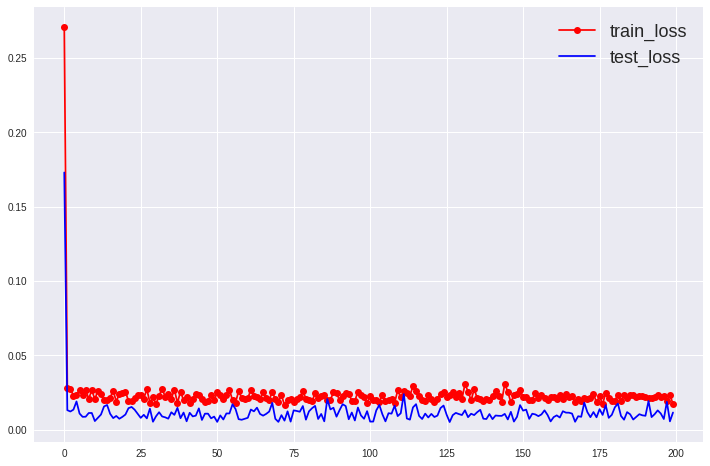

In [17]:
fig = plt.figure(2, figsize=(12, 8))

print(len(avg_train_losses))
print(len(avg_test_losses))
# print(len(test_accuracy))

(l1,) = plt.plot(range(len(avg_train_losses)), avg_train_losses, c="r", marker="o", label="train_loss")
(l2,) = plt.plot(range(len(avg_test_losses)), avg_test_losses, c="b", marker="x", label="test_loss")
# (l3,) = plt.plot(range(len(test_accuracy)), test_accuracy, c="limegreen", marker="^", label="test_accuracy")

plt.legend(handles=[l1, l2], loc="best", fontsize=18)

In [18]:
torch.save(model.state_dict(), "model.pt")

In [11]:
model = RNN(DATA_FEATURE_NUM).to(device)
model.load_state_dict(torch.load("model.pt"))

# Sliding Window Partition

In [33]:
import torch
import numpy as np
from torch.nn.utils.rnn import pack_padded_sequence


def trajectory_partition(trajectory_arr, clip_length, mean, std):
    """ partion trajectory into fragments """

    partition_data = []
    for i in range(trajectory_arr.shape[0]):
        if i + clip_length > trajectory_arr.shape[0]:
            break
        else:
            partition_data.append(z_score_normalization(trajectory_arr[i : i + clip_length, :], mean, std))
    return partition_data


def trajectory_predict(
    model, trajectory_data, clip_length, mean, std, capabilites=FETCH_CAPABILITY_INDEX, packed_sequence=True
):
    """ predict each fragement"""

    capability_list = []
    parition_data = trajectory_partition(np.array(trajectory_data), clip_length, mean, std)

    for pred_x in parition_data:
        pred_x = torch.FloatTensor(pred_x).to(device)
        pred_x = torch.unsqueeze(pred_x, 0)
        if packed_sequence:
            pred_x = pack_padded_sequence(pred_x, torch.tensor([clip_length]), batch_first=True)
        model = model.eval()
        out = model(pred_x)
        pm = torch.max(out, 1)[1].data.cpu().numpy()[0]
        for k in capabilites:
            if capabilites[k] == pm:
                capability_list.append(k)
                break

    return capability_list


def get_keys(d, value):
    return [k for k, v in d.items() if v == value]


def tranform_result(nn_out_list, clip_length, continuous_traj_list):
    segment_res_list = []
    for index, nn_out in enumerate(nn_out_list):

        segment_res = []
        for real_time_point in range(1, len(continuous_traj_list[index]) + 1):
            count_dict = {"move": 0, "pick_cube": 0, "transport": 0, "place_cube": 0}
            if real_time_point < clip_length:
                res_fragment = nn_out[:real_time_point]
            elif real_time_point >= clip_length and real_time_point + clip_length <= len(continuous_traj_list[index]):
                res_fragment = nn_out[real_time_point - 200 : real_time_point]
            elif real_time_point > len(continuous_traj_list[index]) - 200:
                res_fragment = nn_out[real_time_point - 200 :]

            for capability in res_fragment:
                count_dict[capability] += 1

            keys = get_keys(count_dict, max(count_dict.values()))
            random_index = random.randint(1, len(keys)) - 1
            statis_capability = keys[random_index - 1]

            segment_res.append(statis_capability)

        segment_res_list.append(segment_res)
    return segment_res_list


def generate_traj_from_dataset(traj_list, selected_traj_index):
    #     selected_traj_index = np.random.choice(range(len(traj_list)), n_traj, replace=False).tolist()

    print("selected_traj_index: ", selected_traj_index)

    # -----------------------------
    # generate parititioned trajectory
    # -----------------------------
    partitioned_traj_list = []

    for i in selected_traj_index:
        partitioned_traj_list.append(copy.deepcopy(traj_list[i]))

    continuous_traj_list = []
    for i in selected_traj_index:
        _1_traj_dict = traj_list[i]
        _list = []
        _list.extend(_1_traj_dict["move"])
        _list.extend(_1_traj_dict["pick_cube"])
        _list.extend(_1_traj_dict["transport"])
        _list.extend(_1_traj_dict["place_cube"])
        continuous_traj_list.append(_list)

    return continuous_traj_list, partitioned_traj_list

In [37]:
# -----------------------------
# generate parititioned trajectory
# -----------------------------
selected_traj_index = np.random.choice(range(len(traj_list)), 5, replace=False).tolist()
# selected_traj_index = [93, 60, 119, 94, 41]
continuous_traj_list, partitioned_traj_list = generate_traj_from_dataset(traj_list, selected_traj_index)


# CLIP_LEN = 200
z_score_mean = np.load("segment_lstm_mean.npy")
z_score_std = np.load("segment_lstm_std.npy")

# 滑动窗口的预测
nn_out_list = []
for t_index, trace in enumerate(continuous_traj_list):
    print("trajectory: ", t_index + 1, "    trajectory_length: ", len(trace))
    nn_out = trajectory_predict(
        model=model, trajectory_data=trace, clip_length=CLIP_LEN, mean=z_score_mean, std=z_score_std, packed_sequence=False
    )
    nn_out_list.append(nn_out)


# 将滑动窗口的预测结果转化为轨迹预测结果
segment_res_list = tranform_result(nn_out_list, CLIP_LEN, continuous_traj_list)

selected_traj_index:  [93, 60, 119, 94, 41]
trajectory:  1     trajectory_length:  9522
trajectory:  2     trajectory_length:  9672
trajectory:  3     trajectory_length:  10394
trajectory:  4     trajectory_length:  9660
trajectory:  5     trajectory_length:  9575


{'move': 'red', 'pick_cube': 'darkorange', 'transport': 'blue', 'place_cube': 'limegreen'}


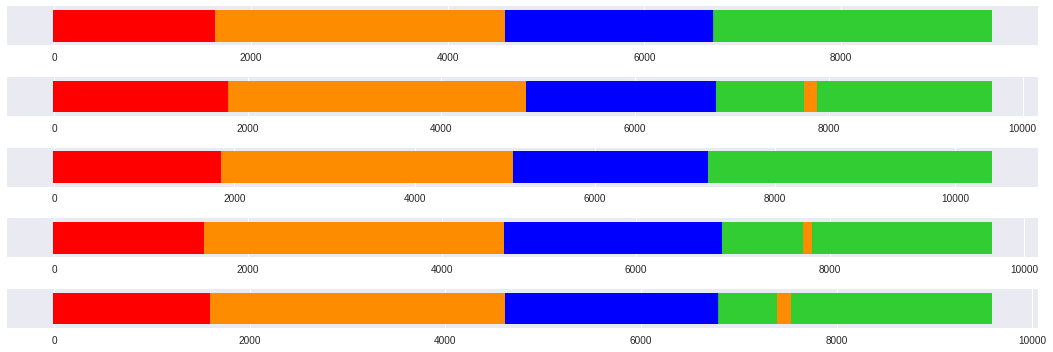

In [38]:
# print segmentation result

motion_colors_map = dict(zip(FETCH_CAPABILITY_INDEX.keys(), ["red", "darkorange", "blue", "limegreen"]))
print(motion_colors_map)
for index, segment_res in enumerate(segment_res_list):

    Y = ["action sequence"] * len(segment_res)
    X = range(len(segment_res))
    # 图像颜色
    c_value = []
    for motion in segment_res:
        c_value.append(motion_colors_map[motion])

    plt.figure(36, figsize=(15, 5))
    plt.subplot(len(segment_res_list), 1, (1 + index))
    plt.tight_layout()
    #     plt.title("Predicted Sequence {}".format(str(index + 1)))
    #     plt.xlabel("time step", fontsize=14)
    #     plt.ylabel("motion primitive", fontsize=14)
    plt.scatter(x=X, y=Y, marker="|", s=1000, c=c_value)

    frame = plt.gca()
    # y 轴不可见
    frame.axes.get_yaxis().set_visible(False)

In [39]:
data_utils._store_in_pickle(segment_res_list, "segment_res.pkl")
plt.savefig("segment_res.png")

<Figure size 432x288 with 0 Axes>

# 对比预测结果

In [ ]:
# motion_colors_map = dict(zip(FETCH_CAPABILITY_BASE, ["darkorange", "limegreen", "red", "blue"]))
# for index, (pred_motion, canonical_motion) in enumerate(zip(predict_res, partitioned_trajectory_list)):

#     print("predict motions: window width: {} , total: {}".format(CLIP_FRAGMENT_LEN, len(pred_motion)))

#     # 图像颜色
#     c_value = []
#     for motion in pred_motion:
#         c_value.append(motion_colors_map[motion])

#     canonical_motion_color = []
#     move_len = len(canonical_motion["move"])
#     canonical_motion_color.extend(zip(["move"] * move_len, [motion_colors_map["move"]] * move_len))

#     pick_len = len(canonical_motion["pick_cube"])
#     canonical_motion_color.extend(zip(["pick_cube"] * pick_len, [motion_colors_map["pick_cube"]] * pick_len))

#     transport_len = len(canonical_motion["transport"])
#     canonical_motion_color.extend(zip(["transport"] * transport_len, [motion_colors_map["transport"]] * transport_len))

#     place_len = len(canonical_motion["place_cube"])
#     canonical_motion_color.extend(zip(["place_cube"] * place_len, [motion_colors_map["place_cube"]] * place_len))

#     print(
#         "canonical motions: move: {}, pick_cube: {}, transport: {}, place_cube: {}, total: {}".format(
#             move_len, pick_len, transport_len, place_len, move_len + pick_len + transport_len + place_len
#         )
#     )
#     print()

#     plt.figure(36, figsize=(12, 20))
#     plt.subplot(6, 2, (1 + index * 2))
#     plt.tight_layout()
#     plt.title("predicted trajectory {}".format(str(index + 1)))
#     plt.xlabel("time step", fontsize=14)
#     plt.ylabel("motion primitive", fontsize=14)
#     plt.scatter(x=range(len(pred_motion)), y=pred_motion, marker="|", s=16, c=c_value)

#     plt.subplot(6, 2, (2 + index * 2))
#     plt.tight_layout()
#     plt.title("canonical trajectory {}".format(str(index + 1)))
#     plt.xlabel("time step", fontsize=14)
#     plt.ylabel("motion primitive", fontsize=14)
#     plt.scatter(
#         x=range(len(canonical_motion_color)),
#         y=[m[0] for m in canonical_motion_color],
#         marker="|",
#         s=16,
#         c=[m[1] for m in canonical_motion_color],
#     )

#     plt.legend([ 'gripper', 'head', 'movebase', 'torso'], loc='best')
#     plt.show()

In [ ]:
# test: pack_padded_sequence pad_packed_sequence pad_sequence

# test_x = [torch.tensor([[1,2],[1,2],[1,2]]), torch.tensor([[3,4],[3,4]]), torch.tensor([[2,3]])]
# test_lengths = [t.size()[0] for t in test_x]

# padded_x = pad_sequence(test_x, batch_first=True, padding_value=0)
# print('padded_x: ', type(padded_x), padded_x)

# packed_padded_x = pack_padded_sequence(padded_x, test_lengths, batch_first=True)
# print('packed_padded_x: ', packed_padded_x)
# print('packed_padded_x.data.size(): ', packed_padded_x.data.size())

# seq_unpacked, lens_unpacked = pad_packed_sequence(packed_padded_x, batch_first=True)
# print('seq_unpacked: ', seq_unpacked)
# print('lens_unpacked: ', lens_unpacked)